In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from collections import Counter
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline as make_pipeline_imb
from imblearn.metrics import classification_report_imbalanced

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

from sklearn.cross_validation import KFold
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve, train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler

from sklearn.metrics import confusion_matrix, classification_report, mean_squared_error
from sklearn.metrics import precision_score, recall_score, f1_score, fbeta_score
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve, classification_report, auc

from mlxtend.plotting import plot_decision_regions, plot_confusion_matrix

import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

sns.set(style='white', context='notebook', palette='deep')

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Load Data

In [2]:
colnames = ['client_no', 'prd_code', 'qrje', 'zfy', 'gmcs', 'trade_date', 'pro_name', 'pro_type']
gmls = pd.read_table("~/Desktop/POCData/g_customer_gmls_20171109.txt", 
                     header = None, names = colnames, dtype={"client_no": np.str},)

In [3]:
gmls.head()

,client_no,prd_code,qrje,zfy,gmcs,trade_date,pro_name,pro_type
0,000000000000003,CI01M03001,511093.0,0,3,20160606,季季添金1号,2
1,000000000000003,CI01M03003,409171.0,0,4,20160505,季季添金3号,2
2,000000000000003,G011209150,1100228.0,0,4,20150917,个人天天盈1号,2
3,000000000000003,GRF1407032,424000.0,0,2,20150804,365天组合投资Z,2
4,000000000000003,GRF1409034,105884.0,0,2,20150921,358天国庆盈金,2


In [4]:
gmls.isnull().sum()/len(gmls)

client_no     0.000000e+00
prd_code      0.000000e+00
qrje          6.807649e-07
zfy           0.000000e+00
gmcs          0.000000e+00
trade_date    0.000000e+00
pro_name      0.000000e+00
pro_type      0.000000e+00
dtype: float64

In [5]:
ent_cols = ['cust_no', 'industry_type', 'rcurrency', 'register_capital', 'scope_new', 'employer_num', 'newtech_corpornot',
           'listing_corpornot', 'other_credit_level', 'mainprod_percent', 'tax_paying', 'std_cert_no_1', 'std_cert_no_2', 
           'core_cust_no', 'etl_date', 'register_capital_rmb']
ent_info = pd.read_table("~/Desktop/POCData/g_customer_ent_info_20171108.txt", header = None, 
                         names = ent_cols,dtype = {'cust_no': np.str, 'employer_num':np.int,'core_cust_no': np.str})
ent_info.head()

,cust_no,industry_type,rcurrency,register_capital,scope_new,employer_num,newtech_corpornot,listing_corpornot,other_credit_level,mainprod_percent,tax_paying,std_cert_no_1,std_cert_no_2,core_cust_no,etl_date,register_capital_rmb
0,010000000001081,G6212,1,1.600000e+07,3,113,1.0,0.0,NaN,0.0,NaN,110108196903308954,110108196903308954,000000005419116,2016-09-30,1.600000e+07
1,010000000001084,E4900,1,5.000000e+05,3,182,0.0,0.0,CCC,0.0,NaN,440104196307162558,650103197003220613,000000007481794,2016-09-30,5.000000e+05
2,010000000001088,H6329,1,5.000000e+05,3,30,0.0,0.0,BBB,0.0,NaN,110105196008291819,110105196008291819,000000005855471,2016-09-30,5.000000e+05
3,010000000001090,L7412,1,1.000000e+09,3,95,0.0,0.0,NaN,0.0,NaN,69169147-9,110108195611170012,NaN,NaN,1.000000e+09
4,010000000001091,C4128,1,1.000000e+07,4,32,0.0,0.0,NaN,0.0,NaN,110105196504245467,NaN,000000010077477,2016-09-30,1.000000e+07


In [6]:
ent_info.isnull().sum() / len(ent_info)

cust_no                 0.000000
industry_type           0.466604
rcurrency               0.000000
register_capital        0.000000
scope_new               0.000000
employer_num            0.000000
newtech_corpornot       0.001153
listing_corpornot       0.000329
other_credit_level      0.543905
mainprod_percent        0.000000
tax_paying              0.946929
std_cert_no_1           0.000000
std_cert_no_2           0.052385
core_cust_no            0.442100
etl_date                0.442100
register_capital_rmb    0.000027
dtype: float64

In [7]:
ent_info.mainprod_percent.unique()

array([0.])

In [8]:
ent_info.etl_date.unique()

array(['2016-09-30', nan], dtype=object)

In [9]:
ent_info = ent_info.drop(labels = ['tax_paying', 'register_capital', 'mainprod_percent', 'etl_date'], axis = 1)

In [10]:
ent_asset_cols = ['customerid',
'guaranteesum',
'assuresum',
'bailratio',
'eachsum',
'guarantyrate',
'evaluatevalue',
'allvalue',
'excessasset',
'excessprofit',
'guarantysum']
ent_asset = pd.read_table("~/Desktop/POCData/g_customer_ent_assets_info_20171108.txt", 
                          header = None, names = ent_asset_cols)
ent_asset.head()

,customerid,guaranteesum,assuresum,bailratio,eachsum,guarantyrate,evaluatevalue,allvalue,excessasset,excessprofit,guarantysum
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,010000000001081,NaN,NaN,NaN,0.0,100.000000,0.0,0.0,0.0,0.0,1.950000e+07
2,010000000001084,NaN,NaN,NaN,0.0,100.000000,0.0,0.0,0.0,0.0,2.000000e+08
3,010000000001088,NaN,NaN,NaN,0.0,81.666667,80000.0,0.0,0.0,0.0,6.600000e+06
4,010000000001089,NaN,NaN,NaN,0.0,98.765432,0.0,0.0,0.0,0.0,5.060228e+09


In [11]:
ent_asset.isnull().sum() / len(ent_asset)

customerid       0.000024
guaranteesum     0.985375
assuresum        0.985375
bailratio        0.985375
eachsum          0.147661
guarantyrate     0.147661
evaluatevalue    0.147661
allvalue         0.147661
excessasset      0.147661
excessprofit     0.147661
guarantysum      0.147661
dtype: float64

In [12]:
sum(ent_asset.eachsum.notnull() & ent_asset.eachsum != 0)

0

In [13]:
sum(ent_asset.evaluatevalue.notnull() & ent_asset.evaluatevalue != 0)

1054

In [14]:
sum(ent_asset.allvalue.notnull() & ent_asset.allvalue != 0)

16

In [15]:
sum(ent_asset.excessasset.notnull() & ent_asset.excessasset != 0)

128

In [16]:
sum(ent_asset.excessprofit.notnull() & ent_asset.excessprofit != 0)

127

In [17]:
ent_asset = ent_asset.drop(['guaranteesum', 'assuresum', 'bailratio', 'eachsum', 'evaluatevalue', 'allvalue', 'excessasset', 'excessprofit'], 1)

In [18]:
ent_loan_act_cols = ['dk60btno',
'dk60date',
'cust_no',
'dk60amntykAvg30',
'dk60amntykMin30',
'dk60amntykMax30',
'dk60amntdkAvg30',
'dk60amntdkMin30',
'dk60amntdkMax30',
'dk60amtdfkAvg30',
'dk60amtdfkMin30',
'dk60amtdfkMax30',
'dk60amntbkAvg30',
'dk60amntbkMin30',
'dk60amntbkMax30',
'dk60amntykAvg15',
'dk60amntykMin15',
'dk60amntykMax15',
'dk60amntdkAvg15',
'dk60amntdkMin15',
'dk60amntdkMax15',
'dk60amtdfkAvg15',
'dk60amtdfkMin15',
'dk60amtdfkMax15',
'dk60amntbkAvg15',
'dk60amntbkMin15',
'dk60amntbkMax15',
'dk60amntykAvg5',
'dk60amntykMin5',
'dk60amntykMax5',
'dk60amntdkAvg5',
'dk60amntdkMin5',
'dk60amntdkMax5',
'dk60amtdfkAvg5',
'dk60amtdfkMin5',
'dk60amtdfkMax5',
'dk60amntbkAvg5',
'dk60amntbkMin5',
'dk60amntbkMax5']
ent_loan_act = pd.read_table("~/Desktop/POCData/g_customer_ent_loan_act_20171108.txt", 
                             header = None, names = ent_loan_act_cols, dtype = {'cust_no': np.str})
ent_loan_act.head()

,dk60btno,dk60date,cust_no,dk60amntykAvg30,dk60amntykMin30,dk60amntykMax30,dk60amntdkAvg30,dk60amntdkMin30,dk60amntdkMax30,dk60amtdfkAvg30,...,dk60amntykMax5,dk60amntdkAvg5,dk60amntdkMin5,dk60amntdkMax5,dk60amtdfkAvg5,dk60amtdfkMin5,dk60amtdfkMax5,dk60amntbkAvg5,dk60amntbkMin5,dk60amntbkMax5
0,021743,20160902,2015102100000131,0.0,0.0,0.0,1.266667e+04,3.800000e+05,3.800000e+05,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,050057,20160920,010000000037195,8000.0,240000.0,240000.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,050137,20160919,010000000070417,0.0,0.0,0.0,6.666667e+06,2.000000e+08,2.000000e+08,79166.666667,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,050148,20160905,010000000068953,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,050153,20160905,010000000068953,0.0,0.0,0.0,4.973652e+04,1.492096e+06,1.492096e+06,175.787667,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
ent_loan_act.isnull().sum() / len(ent_loan_act)

dk60btno           0.000000
dk60date           0.000000
cust_no            0.000000
dk60amntykAvg30    0.000000
dk60amntykMin30    0.000000
dk60amntykMax30    0.000000
dk60amntdkAvg30    0.000000
dk60amntdkMin30    0.000000
dk60amntdkMax30    0.000000
dk60amtdfkAvg30    0.000000
dk60amtdfkMin30    0.000000
dk60amtdfkMax30    0.000000
dk60amntbkAvg30    0.000000
dk60amntbkMin30    0.000000
dk60amntbkMax30    0.000000
dk60amntykAvg15    0.319519
dk60amntykMin15    0.319519
dk60amntykMax15    0.319519
dk60amntdkAvg15    0.319519
dk60amntdkMin15    0.319519
dk60amntdkMax15    0.319519
dk60amtdfkAvg15    0.319519
dk60amtdfkMin15    0.319519
dk60amtdfkMax15    0.319519
dk60amntbkAvg15    0.319519
dk60amntbkMin15    0.319519
dk60amntbkMax15    0.319519
dk60amntykAvg5     0.710319
dk60amntykMin5     0.710319
dk60amntykMax5     0.710319
dk60amntdkAvg5     0.710319
dk60amntdkMin5     0.710319
dk60amntdkMax5     0.710319
dk60amtdfkAvg5     0.710319
dk60amtdfkMin5     0.710319
dk60amtdfkMax5     0

In [20]:
sum(ent_loan_act.dk60amntykMin30 == ent_loan_act.dk60amntykMax30) / len(ent_loan_act)

1.0

In [21]:
sum(ent_loan_act.dk60amntdkMin30 == ent_loan_act.dk60amntdkMax30) / len(ent_loan_act)

1.0

In [22]:
sum(ent_loan_act.dk60amtdfkMin30 == ent_loan_act.dk60amtdfkMax30) / len(ent_loan_act)

1.0

In [23]:
sum(ent_loan_act.dk60amntbkMin30 == ent_loan_act.dk60amntbkMax30) / len(ent_loan_act)

1.0

In [24]:
sum(ent_loan_act.dk60amntykMin15 == ent_loan_act.dk60amntykMax15) / len(ent_loan_act)

0.6804807293825114

In [25]:
sum(ent_loan_act.dk60amntdkMin15 == ent_loan_act.dk60amntdkMax15) / len(ent_loan_act)

0.6804807293825114

In [26]:
sum(ent_loan_act.dk60amtdfkMin15 == ent_loan_act.dk60amtdfkMax15) / len(ent_loan_act)

0.6804807293825114

In [27]:
sum(ent_loan_act.dk60amntbkMin15 == ent_loan_act.dk60amntbkMax15) / len(ent_loan_act)

0.6804807293825114

In [28]:
ent_loan_act = ent_loan_act.drop(labels = ['dk60amntykAvg5','dk60amntykMin5','dk60amntykMax5','dk60amntdkAvg5','dk60amntdkMin5','dk60amntdkMax5','dk60amtdfkAvg5','dk60amtdfkMin5','dk60amtdfkMax5','dk60amntbkAvg5','dk60amntbkMin5','dk60amntbkMax5',
'dk60amntykMin30','dk60amntdkMin30','dk60amtdfkMin30','dk60amntbkMin30','dk60amntykMin15','dk60amntdkMin15','dk60amtdfkMin15','dk60amntbkMin15'], axis = 1)

### Join Forms

In [29]:
indexed_asset = ent_asset.set_index('customerid')
asset_info = pd.merge(ent_info, indexed_asset, left_on='cust_no', right_index=True)

indexed_gmls = gmls.set_index('client_no')
ent_asset_gmls = pd.merge(asset_info, indexed_gmls, how = 'left', left_on='core_cust_no', right_index=True)

ent_summary = pd.merge(ent_asset_gmls, ent_loan_act, how = 'left', on = 'cust_no')
ent_summary.head()

,cust_no,industry_type,rcurrency,scope_new,employer_num,newtech_corpornot,listing_corpornot,other_credit_level,std_cert_no_1,std_cert_no_2,...,dk60amntbkAvg30,dk60amntbkMax30,dk60amntykAvg15,dk60amntykMax15,dk60amntdkAvg15,dk60amntdkMax15,dk60amtdfkAvg15,dk60amtdfkMax15,dk60amntbkAvg15,dk60amntbkMax15
0,010000000001081,G6212,1,3,113,1.0,0.0,NaN,110108196903308954,110108196903308954,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,010000000001084,E4900,1,3,182,0.0,0.0,CCC,440104196307162558,650103197003220613,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,010000000001088,H6329,1,3,30,0.0,0.0,BBB,110105196008291819,110105196008291819,...,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,010000000001090,L7412,1,3,95,0.0,0.0,NaN,69169147-9,110108195611170012,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,010000000001091,C4128,1,4,32,0.0,0.0,NaN,110105196504245467,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [30]:
len(ent_summary)

32228

In [31]:
ent_summary['purchase'] = ent_summary['pro_type'].map(lambda s: 0 if pd.isnull(s) else 1)
ent_summary['has_loan'] = ent_summary['dk60date'].map(lambda s: 0 if pd.isnull(s) else 1)

In [32]:
ent_summary = ent_summary.drop(['pro_type','dk60btno','dk60date','prd_code', 'qrje','zfy', 'gmcs', 'trade_date', 'pro_name'], axis=1)

In [33]:
ent_summary.isnull().sum() / len(ent_summary)

cust_no                 0.000000
industry_type           0.409706
rcurrency               0.000000
scope_new               0.000000
employer_num            0.000000
newtech_corpornot       0.001272
listing_corpornot       0.000341
other_credit_level      0.474711
std_cert_no_1           0.000000
std_cert_no_2           0.041734
core_cust_no            0.342311
register_capital_rmb    0.000000
guarantyrate            0.085330
guarantysum             0.085330
dk60amntykAvg30         0.863380
dk60amntykMax30         0.863380
dk60amntdkAvg30         0.863380
dk60amntdkMax30         0.863380
dk60amtdfkAvg30         0.863380
dk60amtdfkMax30         0.863380
dk60amntbkAvg30         0.863380
dk60amntbkMax30         0.863380
dk60amntykAvg15         0.908061
dk60amntykMax15         0.908061
dk60amntdkAvg15         0.908061
dk60amntdkMax15         0.908061
dk60amtdfkAvg15         0.908061
dk60amtdfkMax15         0.908061
dk60amntbkAvg15         0.908061
dk60amntbkMax15         0.908061
purchase  

In [34]:
ent_summary.shape

(32228, 32)

In [35]:
ent_summary.industry_type.value_counts().sort_values().describe()

count    799.000000
mean      23.809762
std       56.593094
min        1.000000
25%        2.000000
50%        6.000000
75%       21.000000
max      821.000000
Name: industry_type, dtype: float64

### Outliers

In [36]:
numeric_features = ['dk60amntykAvg30',
'dk60amntykMax30',
'dk60amntdkAvg30',
'dk60amntdkMax30',
'dk60amtdfkAvg30',
'dk60amtdfkMax30',
'dk60amntbkAvg30',
'dk60amntbkMax30',
'dk60amntykAvg15',
'dk60amntykMax15',
'dk60amntdkAvg15',
'dk60amntdkMax15',
'dk60amtdfkAvg15',
'dk60amtdfkMax15',
'dk60amntbkAvg15',
'dk60amntbkMax15',
'employer_num',
'register_capital_rmb',
'guarantysum',
'guarantyrate']

In [37]:
for col in numeric_features:
    percent99 = np.percentile(ent_summary[col][ent_summary[col].notnull()], 99)
    indices_to_drop = ent_summary[ent_summary[col] > percent99].index
    ent_summary = ent_summary.drop(indices_to_drop, axis = 0).reset_index(drop=True)

In [38]:
ent_summary.shape

(30714, 32)

In [39]:
ent_summary.isnull().sum()

cust_no                     0
industry_type           12880
rcurrency                   0
scope_new                   0
employer_num                0
newtech_corpornot           8
listing_corpornot           4
other_credit_level      14068
std_cert_no_1               0
std_cert_no_2            1282
core_cust_no            10093
register_capital_rmb        0
guarantyrate             2569
guarantysum              2569
dk60amntykAvg30         26958
dk60amntykMax30         26958
dk60amntdkAvg30         26958
dk60amntdkMax30         26958
dk60amtdfkAvg30         26958
dk60amtdfkMax30         26958
dk60amntbkAvg30         26958
dk60amntbkMax30         26958
dk60amntykAvg15         28193
dk60amntykMax15         28193
dk60amntdkAvg15         28193
dk60amntdkMax15         28193
dk60amtdfkAvg15         28193
dk60amtdfkMax15         28193
dk60amntbkAvg15         28193
dk60amntbkMax15         28193
purchase                    0
has_loan                    0
dtype: int64

### has_credit

In [40]:
ent_summary['has_credit'] = ent_summary['other_credit_level'].map(lambda s: 0 if pd.isnull(s) else 1)

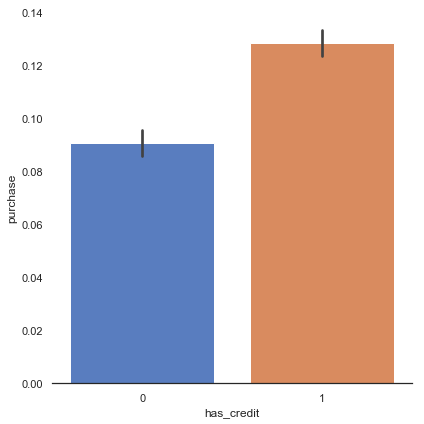

In [41]:
g = sns.factorplot(x="has_credit",y="purchase",data=ent_summary,kind="bar", size = 6 , 
palette = "muted")
g.despine(left=True)
g = g.set_ylabels("purchase")

### guarantysum

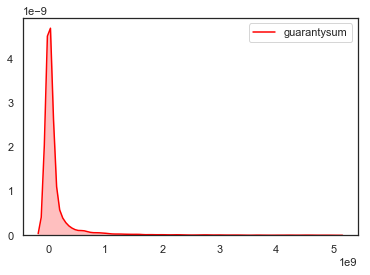

In [42]:
g = sns.kdeplot(ent_summary["guarantysum"][(ent_summary["guarantysum"].notnull())], color="Red", shade = True)

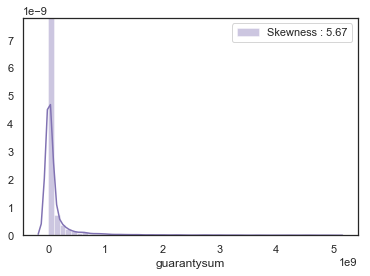

In [43]:
g = sns.distplot(ent_summary["guarantysum"][(ent_summary["guarantysum"].notnull())], color="m", label="Skewness : %.2f"%(ent_summary["guarantysum"][(ent_summary["guarantysum"].notnull())].skew()))
g = g.legend(loc="best")

In [44]:
ent_summary["guarantysum"][(ent_summary["guarantysum"].notnull())] = ent_summary["guarantysum"][(ent_summary["guarantysum"].notnull())].map(lambda i: np.log(i) if i > 0 else 0)

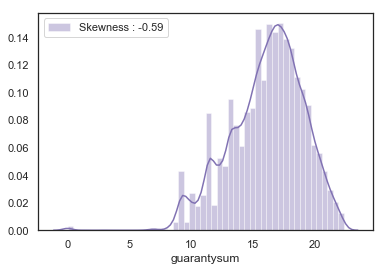

In [45]:
g = sns.distplot(ent_summary["guarantysum"][(ent_summary["guarantysum"].notnull())], color="m", label="Skewness : %.2f"%(ent_summary["guarantysum"][(ent_summary["guarantysum"].notnull())].skew()))
g = g.legend(loc="best")

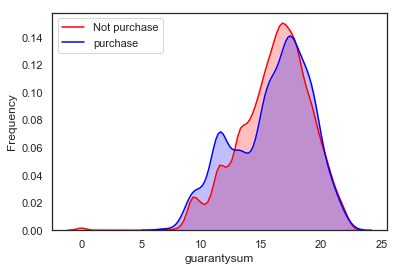

In [46]:
# Explore guarantysum distibution 
g = sns.kdeplot(ent_summary["guarantysum"][(ent_summary["purchase"] == 0) & (ent_summary["guarantysum"].notnull())], color="Red", shade = True)
g = sns.kdeplot(ent_summary["guarantysum"][(ent_summary["purchase"] == 1) & (ent_summary["guarantysum"].notnull())], ax =g, color="Blue", shade= True)
g.set_xlabel("guarantysum")
g.set_ylabel("Frequency")
g = g.legend(["Not purchase","purchase"])

In [47]:
ent_summary["guarantysum"][(ent_summary["purchase"] == 0) & (ent_summary["guarantysum"].notnull())].describe()

count    25107.000000
mean        16.124391
std          2.924237
min          0.000000
25%         14.320820
50%         16.461685
75%         18.165788
max         22.329659
Name: guarantysum, dtype: float64

In [48]:
ent_summary["guarantysum"][(ent_summary["purchase"] == 1) & (ent_summary["guarantysum"].notnull())].describe()

count    3038.000000
mean       15.923028
std         3.145485
min         6.907755
25%        13.399995
50%        16.536806
75%        18.309526
max        22.323205
Name: guarantysum, dtype: float64

### guarantyrate

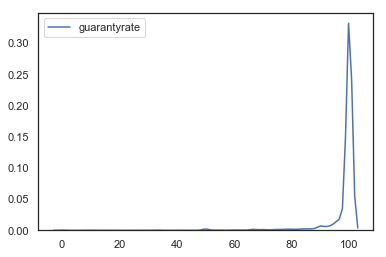

In [49]:
g = sns.kdeplot(ent_summary["guarantyrate"][(ent_summary["guarantyrate"].notnull())])

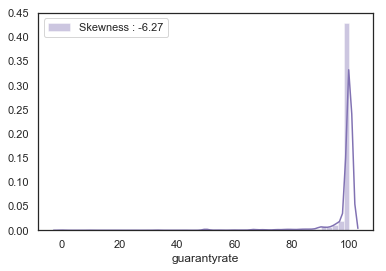

In [50]:
g = sns.distplot(ent_summary["guarantyrate"][(ent_summary["guarantyrate"].notnull())], color="m", label="Skewness : %.2f"%(ent_summary["guarantyrate"][(ent_summary["guarantyrate"].notnull())].skew()))
g = g.legend(loc="best")

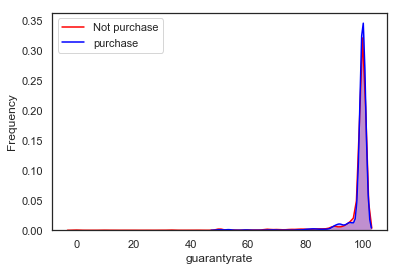

In [51]:
g = sns.kdeplot(ent_summary["guarantyrate"][(ent_summary["purchase"] == 0) & (ent_summary["guarantyrate"].notnull())], color="Red", shade = True)
g = sns.kdeplot(ent_summary["guarantyrate"][(ent_summary["purchase"] == 1) & (ent_summary["guarantyrate"].notnull())], ax =g, color="Blue", shade= True)
g.set_xlabel("guarantyrate")
g.set_ylabel("Frequency")
g = g.legend(["Not purchase","purchase"])

In [52]:
ent_summary["guarantyrate"][(ent_summary["purchase"] == 0) & (ent_summary["guarantyrate"].notnull())].describe()

count    25107.000000
mean        97.884752
std          7.893572
min          0.000000
25%        100.000000
50%        100.000000
75%        100.000000
max        100.000000
Name: guarantyrate, dtype: float64

In [53]:
ent_summary["guarantyrate"][(ent_summary["purchase"] == 1) & (ent_summary["guarantyrate"].notnull())].describe()

count    3038.000000
mean       98.715946
std         4.943894
min        50.000000
25%       100.000000
50%       100.000000
75%       100.000000
max       100.000000
Name: guarantyrate, dtype: float64

### employer_num

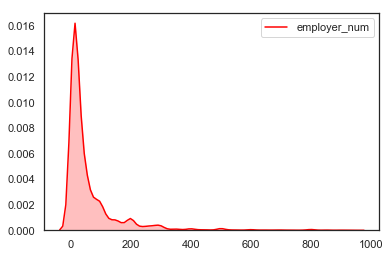

In [54]:
g = sns.kdeplot(ent_summary["employer_num"][(ent_summary["employer_num"].notnull())], color="Red", shade = True)

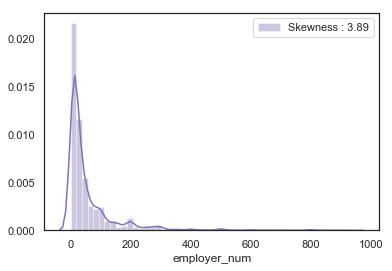

In [55]:
g = sns.distplot(ent_summary["employer_num"][(ent_summary["employer_num"].notnull())], color="m", label="Skewness : %.2f"%(ent_summary["employer_num"][(ent_summary["employer_num"].notnull())].skew()))
g = g.legend(loc="best")

In [56]:
ent_summary["employer_num"][(ent_summary["employer_num"].notnull())] = ent_summary["employer_num"][(ent_summary["employer_num"].notnull())].map(lambda i: np.log(i) if i > 0 else 0)

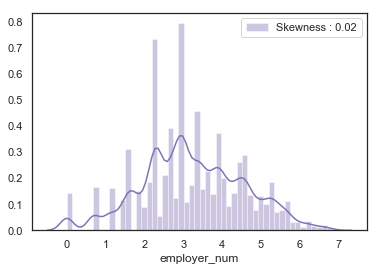

In [57]:
g = sns.distplot(ent_summary["employer_num"][(ent_summary["employer_num"].notnull())], color="m", label="Skewness : %.2f"%(ent_summary["employer_num"][(ent_summary["employer_num"].notnull())].skew()))
g = g.legend(loc="best")

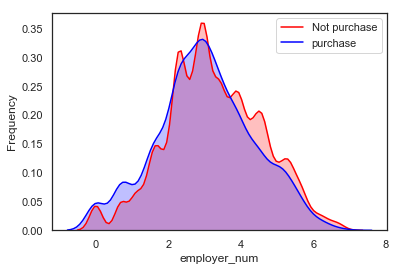

In [58]:
g = sns.kdeplot(ent_summary["employer_num"][(ent_summary["purchase"] == 0) & (ent_summary["employer_num"].notnull())], color="Red", shade = True)
g = sns.kdeplot(ent_summary["employer_num"][(ent_summary["purchase"] == 1) & (ent_summary["employer_num"].notnull())], ax =g, color="Blue", shade= True)
g.set_xlabel("employer_num")
g.set_ylabel("Frequency")
g = g.legend(["Not purchase","purchase"])

In [59]:
ent_summary["employer_num"][(ent_summary["purchase"] == 0) & (ent_summary["employer_num"].notnull())].describe()

count    27296.000000
mean         3.266810
std          1.320095
min          0.000000
25%          2.302585
50%          3.135494
75%          4.219508
max          6.845880
Name: employer_num, dtype: float64

In [60]:
ent_summary["employer_num"][(ent_summary["purchase"] == 1) & (ent_summary["employer_num"].notnull())].describe()

count    3418.000000
mean        3.012327
std         1.337230
min         0.000000
25%         2.302585
50%         2.995732
75%         3.912023
max         6.823286
Name: employer_num, dtype: float64

### register_capital_rmb

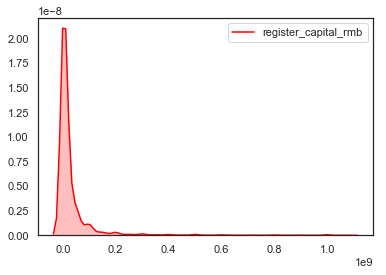

In [61]:
g = sns.kdeplot(ent_summary["register_capital_rmb"][(ent_summary["register_capital_rmb"].notnull())], color="Red", shade = True)

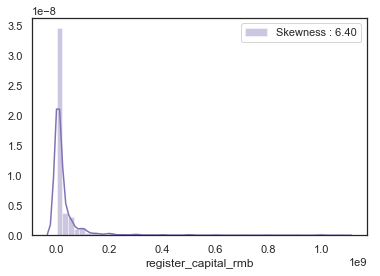

In [62]:
g = sns.distplot(ent_summary["register_capital_rmb"][(ent_summary["register_capital_rmb"].notnull())], color="m", label="Skewness : %.2f"%(ent_summary["register_capital_rmb"][(ent_summary["register_capital_rmb"].notnull())].skew()))
g = g.legend(loc="best")

In [63]:
ent_summary["register_capital_rmb"][(ent_summary["register_capital_rmb"].notnull())] = ent_summary["register_capital_rmb"][(ent_summary["register_capital_rmb"].notnull())].map(lambda i: np.log(i) if i > 0 else 0)

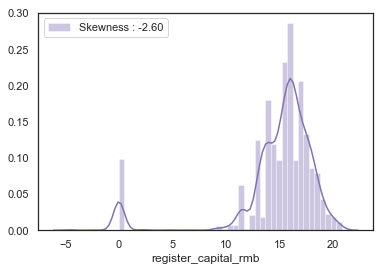

In [64]:
g = sns.distplot(ent_summary["register_capital_rmb"][(ent_summary["register_capital_rmb"].notnull())], color="m", label="Skewness : %.2f"%(ent_summary["register_capital_rmb"][(ent_summary["register_capital_rmb"].notnull())].skew()))
g = g.legend(loc="best")

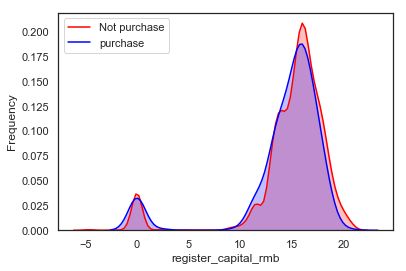

In [65]:
g = sns.kdeplot(ent_summary["register_capital_rmb"][(ent_summary["purchase"] == 0) & (ent_summary["register_capital_rmb"].notnull())], color="Red", shade = True)
g = sns.kdeplot(ent_summary["register_capital_rmb"][(ent_summary["purchase"] == 1) & (ent_summary["register_capital_rmb"].notnull())], ax =g, color="Blue", shade= True)
g.set_xlabel("register_capital_rmb")
g.set_ylabel("Frequency")
g = g.legend(["Not purchase","purchase"])

In [66]:
ent_summary["register_capital_rmb"][(ent_summary["purchase"] == 0) & (ent_summary["register_capital_rmb"].notnull())].describe()

count    27296.000000
mean        14.983391
std          3.952551
min         -4.605170
25%         13.815511
50%         15.894952
75%         17.045759
max         20.800227
Name: register_capital_rmb, dtype: float64

In [67]:
ent_summary["register_capital_rmb"][(ent_summary["purchase"] == 1) & (ent_summary["register_capital_rmb"].notnull())].describe()

count    3418.000000
mean       14.275628
std         4.319162
min         0.000000
25%        13.815511
50%        15.424948
75%        16.523561
max        20.792092
Name: register_capital_rmb, dtype: float64

### dk60amntykMax30

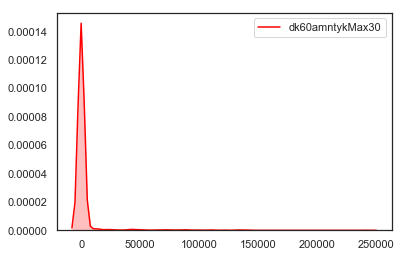

In [68]:
g = sns.kdeplot(ent_summary["dk60amntykMax30"][(ent_summary["dk60amntykMax30"].notnull())], color="Red", shade = True)

In [69]:
sum(ent_summary["dk60amntykMax30"].notnull())

3756

In [70]:
sum(ent_summary["dk60amtdfkMax30"].notnull() & ent_summary["dk60amtdfkMax30"]!=0)

1505

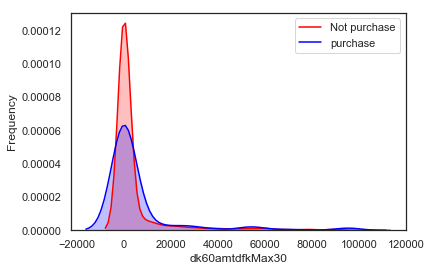

In [71]:
g = sns.kdeplot(ent_summary["dk60amtdfkMax30"][(ent_summary["purchase"] == 0) & (ent_summary["dk60amtdfkMax30"].notnull())], color="Red", shade = True)
g = sns.kdeplot(ent_summary["dk60amtdfkMax30"][(ent_summary["purchase"] == 1) & (ent_summary["dk60amtdfkMax30"].notnull())], ax =g, color="Blue", shade= True)
g.set_xlabel("dk60amtdfkMax30")
g.set_ylabel("Frequency")
g = g.legend(["Not purchase","purchase"])

In [72]:
ent_summary["dk60amtdfkMax30"][(ent_summary["purchase"] == 0) & (ent_summary["dk60amtdfkMax30"].notnull())].describe()

count      3409.000000
mean       4341.257378
std       13345.713619
min           0.000000
25%           0.000000
50%           0.000000
75%         573.080000
max      105486.940000
Name: dk60amtdfkMax30, dtype: float64

In [73]:
ent_summary["dk60amtdfkMax30"][(ent_summary["purchase"] == 1) & (ent_summary["dk60amtdfkMax30"].notnull())].describe()

count      347.000000
mean      5866.814640
std      17325.889999
min          0.000000
25%          0.000000
50%          0.000000
75%         45.680000
max      95404.000000
Name: dk60amtdfkMax30, dtype: float64

In [74]:
ent_summary['dk60amtdfkMax30_log'] = ent_summary['dk60amtdfkMax30'].map(lambda i: np.log(i) if i>0 else np.nan)

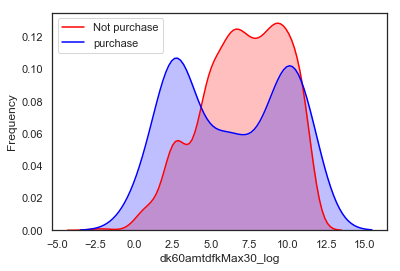

In [75]:
g = sns.kdeplot(ent_summary["dk60amtdfkMax30_log"][(ent_summary["purchase"] == 0) & (ent_summary["dk60amtdfkMax30_log"].notnull())], color="Red", shade = True)
g = sns.kdeplot(ent_summary["dk60amtdfkMax30_log"][(ent_summary["purchase"] == 1) & (ent_summary["dk60amtdfkMax30_log"].notnull())], ax =g, color="Blue", shade= True)
g.set_xlabel("dk60amtdfkMax30_log")
g.set_ylabel("Frequency")
g = g.legend(["Not purchase","purchase"])

### dk60amntykAvg30

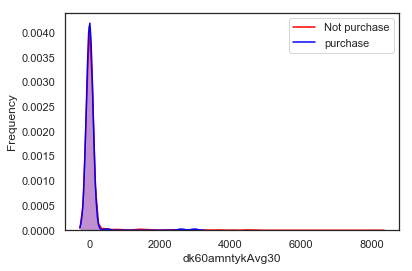

In [76]:
g = sns.kdeplot(ent_summary["dk60amntykAvg30"][(ent_summary["purchase"] == 0) & (ent_summary["dk60amntykAvg30"].notnull())], color="Red", shade = True)
g = sns.kdeplot(ent_summary["dk60amntykAvg30"][(ent_summary["purchase"] == 1) & (ent_summary["dk60amntykAvg30"].notnull())], ax =g, color="Blue", shade= True)
g.set_xlabel("dk60amntykAvg30")
g.set_ylabel("Frequency")
g = g.legend(["Not purchase","purchase"])

In [77]:
ent_summary['dk60amntykAvg30_log'] = ent_summary['dk60amntykAvg30'].map(lambda i: np.log(i) if i>0 else np.nan)

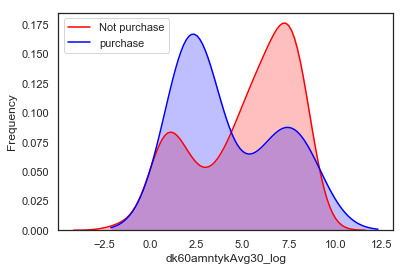

In [78]:
g = sns.kdeplot(ent_summary["dk60amntykAvg30_log"][(ent_summary["purchase"] == 0) & (ent_summary["dk60amntykAvg30_log"].notnull())], color="Red", shade = True)
g = sns.kdeplot(ent_summary["dk60amntykAvg30_log"][(ent_summary["purchase"] == 1) & (ent_summary["dk60amntykAvg30_log"].notnull())], ax =g, color="Blue", shade= True)
g.set_xlabel("dk60amntykAvg30_log")
g.set_ylabel("Frequency")
g = g.legend(["Not purchase","purchase"])

### dk60amntykMax30

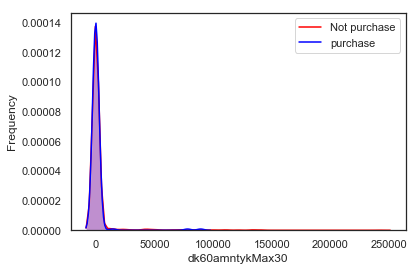

In [79]:
g = sns.kdeplot(ent_summary["dk60amntykMax30"][(ent_summary["purchase"] == 0) & (ent_summary["dk60amntykMax30"].notnull())], color="Red", shade = True)
g = sns.kdeplot(ent_summary["dk60amntykMax30"][(ent_summary["purchase"] == 1) & (ent_summary["dk60amntykMax30"].notnull())], ax =g, color="Blue", shade= True)
g.set_xlabel("dk60amntykMax30")
g.set_ylabel("Frequency")
g = g.legend(["Not purchase","purchase"])

In [80]:
ent_summary['dk60amntykMax30_log'] = ent_summary['dk60amntykMax30'].map(lambda i: np.log(i) if i>0 else np.nan)

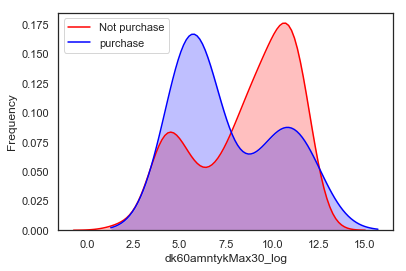

In [81]:
g = sns.kdeplot(ent_summary["dk60amntykMax30_log"][(ent_summary["purchase"] == 0) & (ent_summary["dk60amntykMax30_log"].notnull())], color="Red", shade = True)
g = sns.kdeplot(ent_summary["dk60amntykMax30_log"][(ent_summary["purchase"] == 1) & (ent_summary["dk60amntykMax30_log"].notnull())], ax =g, color="Blue", shade= True)
g.set_xlabel("dk60amntykMax30_log")
g.set_ylabel("Frequency")
g = g.legend(["Not purchase","purchase"])

### dk60amtdfkAvg30

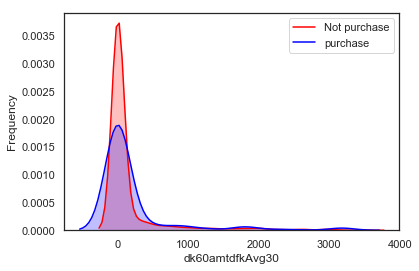

In [82]:
g = sns.kdeplot(ent_summary["dk60amtdfkAvg30"][(ent_summary["purchase"] == 0) & (ent_summary["dk60amtdfkAvg30"].notnull())], color="Red", shade = True)
g = sns.kdeplot(ent_summary["dk60amtdfkAvg30"][(ent_summary["purchase"] == 1) & (ent_summary["dk60amtdfkAvg30"].notnull())], ax =g, color="Blue", shade= True)
g.set_xlabel("dk60amtdfkAvg30")
g.set_ylabel("Frequency")
g = g.legend(["Not purchase","purchase"])

In [83]:
ent_summary['dk60amtdfkAvg30_log'] = ent_summary['dk60amtdfkAvg30'].map(lambda i: np.log(i) if i>0 else np.nan)

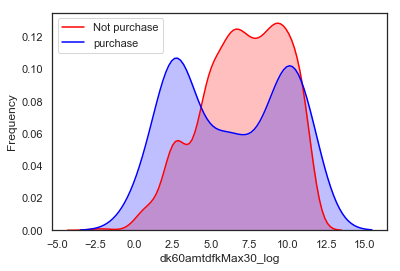

In [84]:
g = sns.kdeplot(ent_summary["dk60amtdfkMax30_log"][(ent_summary["purchase"] == 0) & (ent_summary["dk60amtdfkMax30_log"].notnull())], color="Red", shade = True)
g = sns.kdeplot(ent_summary["dk60amtdfkMax30_log"][(ent_summary["purchase"] == 1) & (ent_summary["dk60amtdfkMax30_log"].notnull())], ax =g, color="Blue", shade= True)
g.set_xlabel("dk60amtdfkMax30_log")
g.set_ylabel("Frequency")
g = g.legend(["Not purchase","purchase"])

## Log Transformation

In [85]:
ent_summary = ent_summary.drop(['dk60amtdfkMax30_log','dk60amntykAvg30_log','dk60amntykMax30_log','dk60amtdfkAvg30_log'],1)

In [86]:
to_log = ['dk60amntykAvg30', 'dk60amntykMax30', 'dk60amtdfkAvg30', 'dk60amtdfkMax30', 'dk60amntdkAvg30', 'dk60amntdkMax30',
         'dk60amntbkAvg30', 'dk60amntbkMax30', 'dk60amntykAvg15', 'dk60amntykMax15', 'dk60amtdfkAvg15', 'dk60amtdfkMax15', 
          'dk60amntdkAvg15', 'dk60amntdkMax15','dk60amntbkAvg15', 'dk60amntbkMax15']
for col in to_log:
    ent_summary[col][(ent_summary[col].notnull())] = ent_summary[col][(ent_summary[col].notnull())].map(lambda i: np.log(i) if i > 0 else 0)

### dk60amntdkAvg30

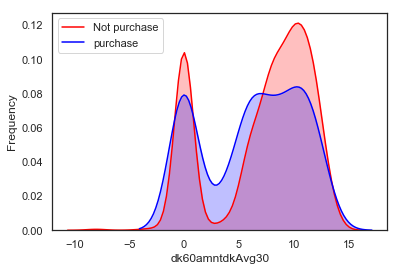

In [87]:
g = sns.kdeplot(ent_summary["dk60amntdkAvg30"][(ent_summary["purchase"] == 0) & (ent_summary["dk60amntdkAvg30"].notnull())], color="Red", shade = True)
g = sns.kdeplot(ent_summary["dk60amntdkAvg30"][(ent_summary["purchase"] == 1) & (ent_summary["dk60amntdkAvg30"].notnull())], ax =g, color="Blue", shade= True)
g.set_xlabel("dk60amntdkAvg30")
g.set_ylabel("Frequency")
g = g.legend(["Not purchase","purchase"])

In [88]:
ent_summary["dk60amntdkAvg30"][(ent_summary["purchase"] == 0) & (ent_summary["dk60amntdkAvg30"].notnull())].describe()

count    3409.000000
mean        7.178100
std         4.437707
min        -8.006368
25%         5.298317
50%         8.448200
75%        10.463103
max        13.815511
Name: dk60amntdkAvg30, dtype: float64

In [89]:
ent_summary["dk60amntdkAvg30"][(ent_summary["purchase"] == 1) & (ent_summary["dk60amntdkAvg30"].notnull())].describe()

count    347.000000
mean       6.220043
std        4.381658
min        0.000000
25%        0.000000
50%        6.725434
75%       10.414313
max       13.053371
Name: dk60amntdkAvg30, dtype: float64

### A_credit

In [90]:
ent_summary = ent_summary.drop(['has_loan', 'newtech_corpornot'], 1)

In [91]:
ent_summary.loc[ent_summary['other_credit_level'] == 'C', 'other_credit_level'] = 0
ent_summary.loc[ent_summary['other_credit_level'] == 'CC', 'other_credit_level'] = 1
ent_summary.loc[ent_summary['other_credit_level'] == 'CCC', 'other_credit_level'] = 2
ent_summary.loc[ent_summary['other_credit_level'] == 'B', 'other_credit_level'] = 3
ent_summary.loc[ent_summary['other_credit_level'] == 'BB', 'other_credit_level'] = 4
ent_summary.loc[ent_summary['other_credit_level'] == 'BBB', 'other_credit_level'] = 5
ent_summary.loc[ent_summary['other_credit_level'] == 'A', 'other_credit_level'] = 6
ent_summary.loc[ent_summary['other_credit_level'] == 'AA', 'other_credit_level'] = 7
ent_summary.loc[ent_summary['other_credit_level'] == 'AAA', 'other_credit_level'] = 8
ent_summary['A_credit'] = ent_summary['other_credit_level'].map(lambda s: 1 if (5 < s) else 0)

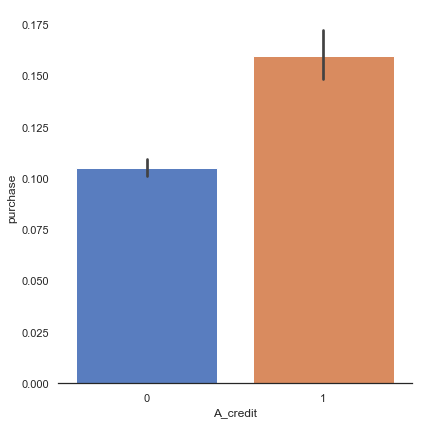

In [92]:
g = sns.factorplot(x="A_credit",y="purchase",data=ent_summary,kind="bar", size = 6 , 
palette = "muted")
g.despine(left=True)
g = g.set_ylabels("purchase")

### feature transformation

In [93]:
ent_summary.scope_new = ent_summary.scope_new - 3

In [94]:
ent_summary.loc[ent_summary['rcurrency'] != 1, 'rcurrency'] = 0

In [95]:
ent_summary.loc[ent_summary['listing_corpornot'] > 1, 'listing_corpornot'] = 1

### rcurrency

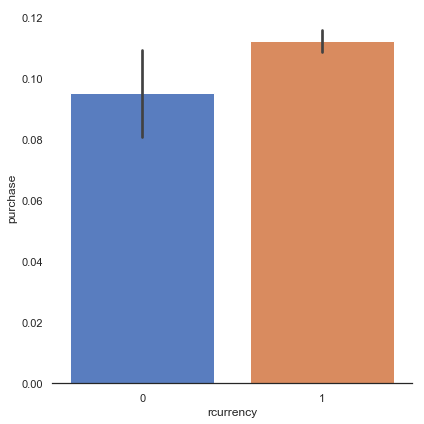

In [96]:
g = sns.factorplot(x="rcurrency",y="purchase",data=ent_summary,kind="bar", size = 6 , 
palette = "muted")
g.despine(left=True)
g = g.set_ylabels("purchase")

### Listing corporate or not

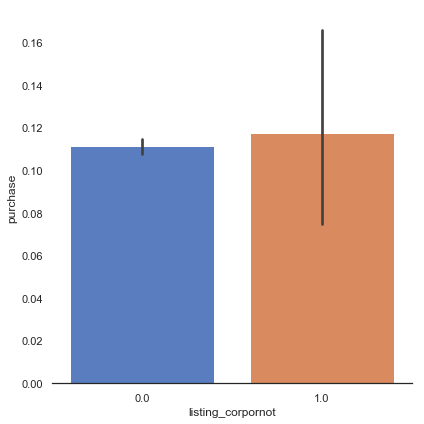

In [97]:
g = sns.factorplot(x="listing_corpornot",y="purchase",data=ent_summary,kind="bar", size = 6 , 
palette = "muted")
g.despine(left=True)
g = g.set_ylabels("purchase")

### scope

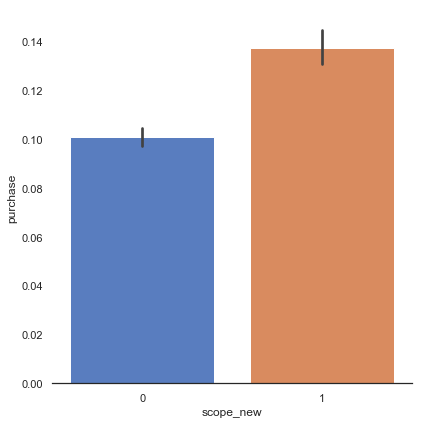

In [98]:
g = sns.factorplot(x="scope_new",y="purchase",data=ent_summary,kind="bar", size = 6 , 
palette = "muted")
g.despine(left=True)
g = g.set_ylabels("purchase")

### has_credit

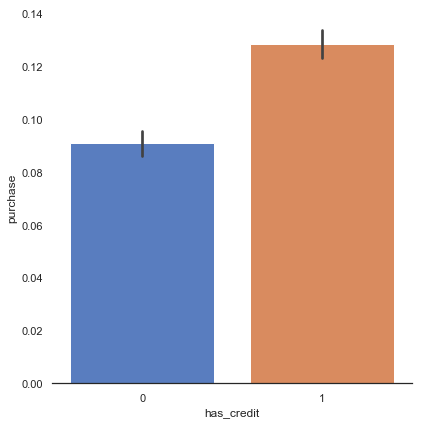

In [99]:
g = sns.factorplot(x="has_credit",y="purchase",data=ent_summary,kind="bar", size = 6 , 
palette = "muted")
g.despine(left=True)
g = g.set_ylabels("purchase")

In [100]:
ent_summary.isnull().sum()

cust_no                     0
industry_type           12880
rcurrency                   0
scope_new                   0
employer_num                0
listing_corpornot           4
other_credit_level      14068
std_cert_no_1               0
std_cert_no_2            1282
core_cust_no            10093
register_capital_rmb        0
guarantyrate             2569
guarantysum              2569
dk60amntykAvg30         26958
dk60amntykMax30         26958
dk60amntdkAvg30         26958
dk60amntdkMax30         26958
dk60amtdfkAvg30         26958
dk60amtdfkMax30         26958
dk60amntbkAvg30         26958
dk60amntbkMax30         26958
dk60amntykAvg15         28193
dk60amntykMax15         28193
dk60amntdkAvg15         28193
dk60amntdkMax15         28193
dk60amtdfkAvg15         28193
dk60amtdfkMax15         28193
dk60amntbkAvg15         28193
dk60amntbkMax15         28193
purchase                    0
has_credit                  0
A_credit                    0
dtype: int64

### fill missing values

In [101]:
ent_summary['listing_corpornot'] = ent_summary['listing_corpornot'].fillna(ent_summary['listing_corpornot'].mode()[0])

In [102]:
ent_summary['guarantyrate'] = ent_summary['guarantyrate'].fillna(ent_summary['guarantyrate'].median())

In [103]:
ent_summary['guarantysum'] = ent_summary['guarantysum'].fillna(ent_summary['guarantysum'].median())

In [104]:
for col in to_log:
    ent_summary[col] = ent_summary[col].fillna(0)

### age

In [105]:
ent_summary["age"] = pd.Series([i[6:10] for i in ent_summary["std_cert_no_1"] ])
ent_summary["age"] = 2017 - pd.to_numeric(ent_summary['age'], errors='coerce')

In [106]:
ent_summary = ent_summary.drop(['dk60amntbkMax30','dk60amntbkMax15','dk60amntbkAvg30', 'dk60amntbkAvg15'], 1)

In [107]:
ent_summary['age'] = [np.nan if (i < 0) | (i > 100) else i for i in ent_summary['age']]

In [108]:
ent_summary['age'] = ent_summary['age'].fillna(ent_summary['age'].median())

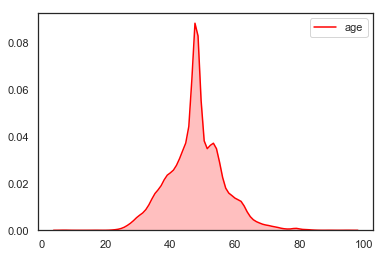

In [109]:
g = sns.kdeplot(ent_summary["age"][ent_summary.age.notnull()], color="Red", shade = True)

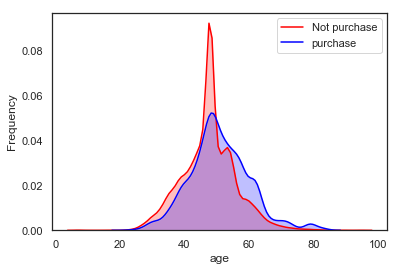

In [110]:
g = sns.kdeplot(ent_summary["age"][(ent_summary["purchase"] == 0) & (ent_summary["age"].notnull())], color="Red", shade = True)
g = sns.kdeplot(ent_summary["age"][(ent_summary["purchase"] == 1) & (ent_summary["age"].notnull())], ax =g, color="Blue", shade= True)
g.set_xlabel("age")
g.set_ylabel("Frequency")
g = g.legend(["Not purchase","purchase"])

In [111]:
ent_summary["age"][(ent_summary["purchase"] == 0) & (ent_summary["age"].notnull())].describe()

count    27296.000000
mean        47.718310
std          8.244454
min          7.000000
25%         43.000000
50%         48.000000
75%         53.000000
max         95.000000
Name: age, dtype: float64

In [112]:
ent_summary["age"][(ent_summary["purchase"] == 1) & (ent_summary["age"].notnull())].describe()

count    3418.000000
mean       50.967525
std         9.250796
min        23.000000
25%        45.000000
50%        50.000000
75%        57.000000
max        83.000000
Name: age, dtype: float64

### regularization

In [113]:
def zscore(col):
    return [(x - col.mean()) / col.std() for x in col]

In [114]:
to_zscore = ['employer_num',
'register_capital_rmb',
'guarantysum',
'guarantyrate',
'age',
'dk60amntykAvg30',           
'dk60amntykMax30',           
'dk60amtdfkAvg30',           
'dk60amtdfkMax30',           
'dk60amntdkAvg30',           
'dk60amntdkMax30',
'dk60amntykAvg15',             
'dk60amntykMax15',             
'dk60amntdkAvg15',             
'dk60amntdkMax15',             
'dk60amtdfkAvg15',             
'dk60amtdfkMax15']          

In [115]:
for col in to_zscore:
    ent_summary[col] = zscore(ent_summary[col])

In [116]:
ent_summary.isnull().sum()

cust_no                     0
industry_type           12880
rcurrency                   0
scope_new                   0
employer_num                0
listing_corpornot           0
other_credit_level      14068
std_cert_no_1               0
std_cert_no_2            1282
core_cust_no            10093
register_capital_rmb        0
guarantyrate                0
guarantysum                 0
dk60amntykAvg30             0
dk60amntykMax30             0
dk60amntdkAvg30             0
dk60amntdkMax30             0
dk60amtdfkAvg30             0
dk60amtdfkMax30             0
dk60amntykAvg15             0
dk60amntykMax15             0
dk60amntdkAvg15             0
dk60amntdkMax15             0
dk60amtdfkAvg15             0
dk60amtdfkMax15             0
purchase                    0
has_credit                  0
A_credit                    0
age                         0
dtype: int64

In [117]:
ent_summary.describe()

,rcurrency,scope_new,employer_num,listing_corpornot,register_capital_rmb,guarantyrate,guarantysum,dk60amntykAvg30,dk60amntykMax30,dk60amntdkAvg30,...,dk60amntykAvg15,dk60amntykMax15,dk60amntdkAvg15,dk60amntdkMax15,dk60amtdfkAvg15,dk60amtdfkMax15,purchase,has_credit,A_credit,age
count,30714.000000,30714.000000,3.071400e+04,30714.000000,3.071400e+04,3.071400e+04,3.071400e+04,3.071400e+04,3.071400e+04,3.071400e+04,...,3.071400e+04,3.071400e+04,3.071400e+04,3.071400e+04,3.071400e+04,3.071400e+04,30714.000000,30714.000000,30714.000000,3.071400e+04
mean,0.947548,0.284626,-1.924763e-16,0.006088,3.997584e-16,5.108024e-16,1.628645e-16,1.295513e-17,1.295513e-17,-3.701466e-18,...,-2.961173e-17,2.220880e-17,-4.071613e-17,1.036411e-16,7.402933e-18,3.701466e-17,0.111285,0.541968,0.112750,5.922346e-17
std,0.222940,0.451243,1.000000e+00,0.077792,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.314490,0.498244,0.316292,1.000000e+00
min,0.000000,0.000000,-2.445230e+00,0.000000,-4.876066e+00,-1.338974e+01,-5.710375e+00,-2.867318e+00,-9.068955e-02,-3.175951e+00,...,-1.515769e+00,-8.640399e-02,-3.352712e+00,-1.793440e+00,-8.154272e+00,-2.535811e+00,0.000000,0.000000,0.000000,-4.876257e+00
25%,1.000000,0.000000,-7.066572e-01,0.000000,-2.722020e-01,2.532282e-01,-5.752211e-01,-8.423735e-02,-9.068955e-02,-3.103105e-01,...,-8.201780e-02,-8.640399e-02,-2.442684e-01,-2.476535e-01,-1.257463e-01,-1.512123e-01,0.000000,0.000000,0.000000,-6.029929e-01
50%,1.000000,0.000000,-1.113305e-01,0.000000,2.101786e-01,2.532282e-01,1.210132e-01,-8.423735e-02,-9.068955e-02,-3.103105e-01,...,-8.201780e-02,-8.640399e-02,-2.442684e-01,-2.476535e-01,-1.257463e-01,-1.512123e-01,0.000000,1.000000,0.000000,-9.484083e-03
75%,1.000000,1.000000,6.830545e-01,0.000000,5.090667e-01,2.532282e-01,6.569194e-01,-8.423735e-02,-9.068955e-02,-3.103105e-01,...,-8.201780e-02,-8.640399e-02,-2.442684e-01,-2.476535e-01,-1.257463e-01,-1.512123e-01,0.000000,1.000000,0.000000,5.840248e-01
max,1.000000,1.000000,2.723769e+00,1.000000,1.473482e+00,2.532282e-01,2.192922e+00,1.648856e+01,1.466853e+01,4.634540e+00,...,1.596300e+01,1.478409e+01,5.750216e+00,5.395263e+00,1.200413e+01,1.018513e+01,1.000000,1.000000,1.000000,5.569499e+00


### summary

In [118]:
ent_summary = ent_summary.drop(['other_credit_level', 'cust_no', 'core_cust_no', 'std_cert_no_1', 'std_cert_no_2','industry_type'], 1)

In [119]:
ent_summary.shape

(30714, 23)

purchase
0    27296
1     3418
dtype: int64


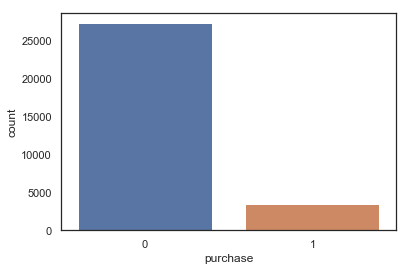

In [120]:
print(ent_summary.groupby('purchase').size())

sns.countplot(x="purchase", data=ent_summary)

In [121]:
ent_summary.dtypes

rcurrency                 int64
scope_new                 int64
employer_num            float64
listing_corpornot       float64
register_capital_rmb    float64
guarantyrate            float64
guarantysum             float64
dk60amntykAvg30         float64
dk60amntykMax30         float64
dk60amntdkAvg30         float64
dk60amntdkMax30         float64
dk60amtdfkAvg30         float64
dk60amtdfkMax30         float64
dk60amntykAvg15         float64
dk60amntykMax15         float64
dk60amntdkAvg15         float64
dk60amntdkMax15         float64
dk60amtdfkAvg15         float64
dk60amtdfkMax15         float64
purchase                  int64
has_credit                int64
A_credit                  int64
age                     float64
dtype: object

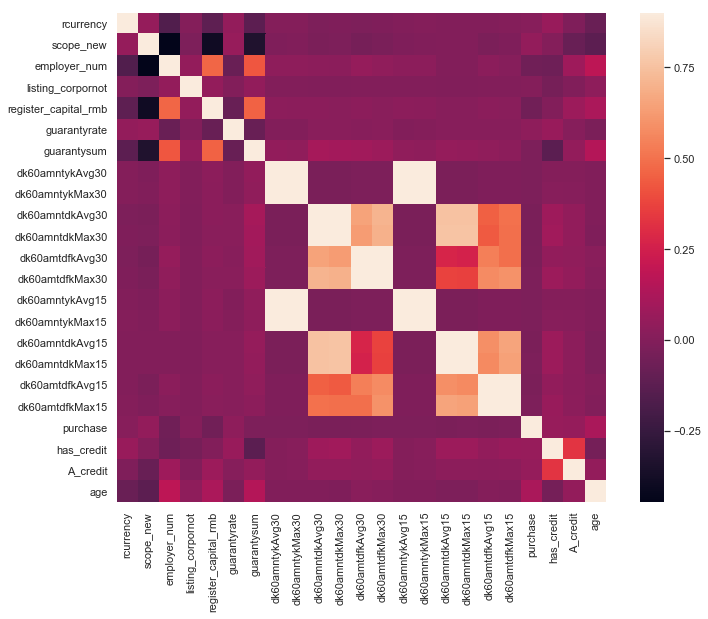

In [122]:
#Correlation map to see how features are correlated with SalePrice
corrmat = ent_summary.corr()
plt.subplots(figsize=(12,9))
sns.heatmap(corrmat, vmax=0.9, square=True)

In [123]:
ent_summary.head()

,rcurrency,scope_new,employer_num,listing_corpornot,register_capital_rmb,guarantyrate,guarantysum,dk60amntykAvg30,dk60amntykMax30,dk60amntdkAvg30,...,dk60amntykAvg15,dk60amntykMax15,dk60amntdkAvg15,dk60amntdkMax15,dk60amtdfkAvg15,dk60amtdfkMax15,purchase,has_credit,A_credit,age
0,1,0,1.124196,0.0,0.420749,0.253228,0.230789,-0.084237,-0.09069,-0.310311,...,-0.082018,-0.086404,-0.244268,-0.247653,-0.125746,-0.151212,0,0,0,-0.009484
1,1,0,1.484068,0.0,-0.445440,0.253228,1.054720,-0.084237,-0.09069,-0.310311,...,-0.082018,-0.086404,-0.244268,-0.247653,-0.125746,-0.151212,0,1,0,0.702727
2,1,0,0.122853,0.0,-0.445440,-2.247983,-0.152648,-0.084237,-0.09069,3.169091,...,-0.082018,-0.086404,-0.244268,-0.247653,-0.125746,-0.151212,0,1,0,1.058832
3,1,0,0.993186,0.0,1.454247,0.253228,1.795109,-0.084237,-0.09069,-0.310311,...,-0.082018,-0.086404,-0.244268,-0.247653,-0.125746,-0.151212,0,0,0,-0.009484
4,1,1,0.171583,0.0,0.303281,0.253228,-0.230288,-0.084237,-0.09069,-0.310311,...,-0.082018,-0.086404,-0.244268,-0.247653,-0.125746,-0.151212,0,0,0,0.465323


In [124]:
ent_summary = ent_summary.sample(frac=1).reset_index(drop=True)

In [125]:
ent_summary.head()

,rcurrency,scope_new,employer_num,listing_corpornot,register_capital_rmb,guarantyrate,guarantysum,dk60amntykAvg30,dk60amntykMax30,dk60amntdkAvg30,...,dk60amntykAvg15,dk60amntykMax15,dk60amntdkAvg15,dk60amntdkMax15,dk60amtdfkAvg15,dk60amtdfkMax15,purchase,has_credit,A_credit,age
0,1,0,-2.445230,0.0,0.705526,0.253228,-1.246683,-0.084237,-0.09069,-0.310311,...,-0.082018,-0.086404,-0.244268,-0.247653,-0.125746,-0.151212,0,0,0,-1.433905
1,1,0,1.555278,0.0,0.959262,-0.201537,1.158307,-0.084237,-0.09069,-0.310311,...,-0.082018,-0.086404,-0.244268,-0.247653,-0.125746,-0.151212,0,0,0,-0.128186
2,1,0,1.747546,0.0,0.247511,-0.981136,1.040659,-0.084237,-0.09069,-0.310311,...,-0.082018,-0.086404,-0.244268,-0.247653,-0.125746,-0.151212,1,1,0,1.177534
3,1,0,-0.351780,0.0,-0.445440,0.253228,-0.169113,-0.084237,-0.09069,3.337315,...,-0.082018,-0.086404,4.382050,4.314805,10.192390,9.041830,0,1,1,0.465323
4,1,0,1.512564,0.0,0.479006,0.253228,1.320491,-0.084237,-0.09069,2.738165,...,-0.082018,-0.086404,3.670536,3.752912,-0.125746,-0.151212,0,0,0,-0.365589


### feature selection

In [126]:
y = ent_summary["purchase"]
X = ent_summary.drop(labels = ["purchase"],axis = 1)

In [129]:
# splitting data into training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=4, test_size=0.20)

In [130]:
rf = RandomForestClassifier(random_state=2).fit(X_train, y_train)

In [131]:
cols = ent_summary.drop(['purchase'], 1).columns.values
# Create a dataframe with features
feature_dataframe = pd.DataFrame( {'features': cols,
     'feature importances': rf.feature_importances_
    })

In [132]:
feature_dataframe = feature_dataframe.sort_values(by=['feature importances'], ascending=False)

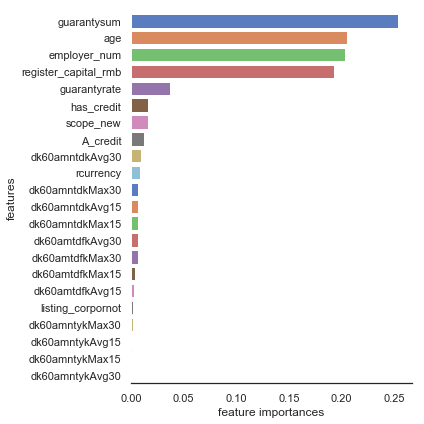

In [133]:
g = sns.factorplot(x="feature importances",y="features",data=feature_dataframe,kind="bar", size = 6 , 
palette = "muted")
g.despine(left=True)

In [134]:
feature_dataframe

,features,feature importances
6,guarantysum,0.254073
21,age,0.205202
2,employer_num,0.203092
4,register_capital_rmb,0.193292
5,guarantyrate,0.037462
19,has_credit,0.016446
1,scope_new,0.015657
20,A_credit,0.011930
9,dk60amntdkAvg30,0.009072
0,rcurrency,0.008776


In [135]:
ent_summary = ent_summary.drop(['dk60amntykAvg15','dk60amntykMax30','dk60amntykMax15','dk60amntykAvg30'],1)

### train

In [136]:
y = ent_summary["purchase"]
X = ent_summary.drop(labels = ["purchase"],axis = 1)

In [137]:
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb

In [148]:
def print_results(headline, true_value, pred):
    print(headline)
    print("accuracy: {}".format(accuracy_score(true_value, pred)))
    print("precision: {}".format(precision_score(true_value, pred)))
    print("recall: {}".format(recall_score(true_value, pred)))
    print("f2: {}".format(fbeta_score(true_value, pred, beta=2)))

In [139]:
# splitting data into training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=4, test_size=0.20)

In [151]:
def evaluatemodel(classifier, name):
    # build model with SMOTE imblearn
    smote_pipeline = make_pipeline_imb(SMOTE(random_state=6), \
                                   classifier)

    smote_model = smote_pipeline.fit(X_train, y_train)
    smote_prediction = smote_model.predict(X_test)

    print("normal data distribution: {}".format(Counter(y)))
    X_smote, y_smote = SMOTE().fit_sample(X, y)
    print("SMOTE data distribution: {}".format(Counter(y_smote)))
    
    print("Confusion Matrix: ")
    print(confusion_matrix(y_test, smote_prediction))
    #plot_confusion_matrix(confusion_matrix(y_test, smote_prediction))

    print('\nSMOTE Pipeline Score {}'.format(smote_pipeline.score(X_test, y_test)))

    print_results("\nSMOTE + " + name + " classification", y_test, smote_prediction)

In [141]:
def ROC(classifer, name):
    # build model with SMOTE imblearn
    smote_pipeline = make_pipeline_imb(SMOTE(random_state=6), \
                                   classifier)

    smote_model = smote_pipeline.fit(X_train, y_train)
    smote_prediction = smote_model.predict(X_test) 
    X_smote, y_smote = SMOTE().fit_sample(X, y)
    print_results("\nSMOTE + " + name + " classification")

    # Compute predicted probabilities: y_pred_prob
    y_pred_prob = smote_pipeline.predict_proba(X_test)[:,1]

    # Generate ROC curve values: fpr, tpr, thresholds
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
    print('AUC:', auc(fpr, tpr))

    # Plot ROC curve
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.show()

normal data distribution: Counter({0: 27296, 1: 3418})
SMOTE data distribution: Counter({0: 27296, 1: 27296})
Confusion Matrix: 
[[5390   85]
 [  92  576]]

SMOTE Pipeline Score 0.9711867165879863

SMOTE + RandomForest classification
accuracy: 0.9711867165879863
precision: 0.8714069591527988
recall: 0.8622754491017964
f2: 0.8640864086408641
AUC: 0.94584310830394


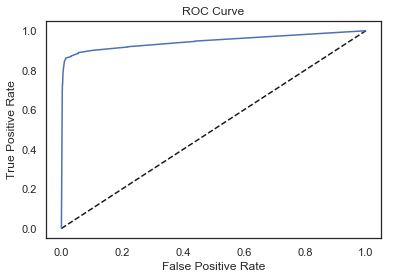

In [150]:
classifier = RandomForestClassifier(random_state=2)
name = "RandomForest"

smote_pipeline = make_pipeline_imb(SMOTE(random_state=6), \
                                   classifier)

smote_model = smote_pipeline.fit(X_train, y_train)
smote_prediction = smote_model.predict(X_test)

print("normal data distribution: {}".format(Counter(y)))
X_smote, y_smote = SMOTE().fit_sample(X, y)
print("SMOTE data distribution: {}".format(Counter(y_smote)))
    
print("Confusion Matrix: ")
print(confusion_matrix(y_test, smote_prediction))
#plot_confusion_matrix(confusion_matrix(y_test, smote_prediction))

print('\nSMOTE Pipeline Score {}'.format(smote_pipeline.score(X_test, y_test)))

print_results("\nSMOTE + " + name + " classification", y_test, smote_prediction)

# Compute predicted probabilities: y_pred_prob
y_pred_prob = smote_pipeline.predict_proba(X_test)[:,1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
print('AUC:', auc(fpr, tpr))

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

In [152]:
evaluatemodel(RandomForestClassifier(random_state=2), "RandomForest")

normal data distribution: Counter({0: 27296, 1: 3418})
SMOTE data distribution: Counter({0: 27296, 1: 27296})
Confusion Matrix: 
[[5390   85]
 [  92  576]]

SMOTE Pipeline Score 0.9711867165879863

SMOTE + RandomForest classification
accuracy: 0.9711867165879863
precision: 0.8714069591527988
recall: 0.8622754491017964
f2: 0.8640864086408641


normal data distribution: Counter({0: 26796, 1: 3375})
SMOTE data distribution: Counter({0: 26796, 1: 26796})
Confusion Matrix: 

SMOTE Pipeline Score 0.9595691797845899

SMOTE + AdaBoost classification
accuracy: 0.9595691797845899
precision: 0.7732793522267206
recall: 0.8828967642526965
f1: 0.8244604316546762


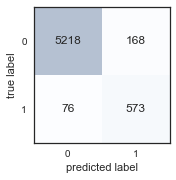

In [114]:
evaluatemodel(AdaBoostClassifier(DecisionTreeClassifier(random_state=2),random_state=2,learning_rate=0.1), "AdaBoost")

normal data distribution: Counter({0: 26796, 1: 3375})
SMOTE data distribution: Counter({0: 26796, 1: 26796})
Confusion Matrix: 

SMOTE Pipeline Score 0.9739850869925435

SMOTE + AdaBoost classification
accuracy: 0.9739850869925435
precision: 0.8682634730538922
recall: 0.8936825885978429
f1: 0.8807896735003797


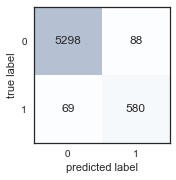

In [115]:
evaluatemodel(AdaBoostClassifier(DecisionTreeClassifier(random_state=2),random_state=2,learning_rate=0.3, n_estimators=100), "AdaBoost")

normal data distribution: Counter({0: 26796, 1: 3375})
SMOTE data distribution: Counter({0: 26796, 1: 26796})
Confusion Matrix: 

SMOTE Pipeline Score 0.9741507870753935

SMOTE + ExtraTrees classification
accuracy: 0.9741507870753935
precision: 0.8845553822152886
recall: 0.8736517719568567
f1: 0.8790697674418604


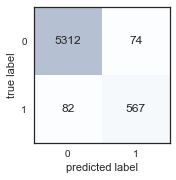

In [121]:
evaluatemodel(ExtraTreesClassifier(random_state=2), "ExtraTrees")

normal data distribution: Counter({0: 26796, 1: 3375})
SMOTE data distribution: Counter({0: 26796, 1: 26796})
Confusion Matrix: 

SMOTE Pipeline Score 0.9756420878210439

SMOTE + ExtraTrees classification
accuracy: 0.9756420878210439
precision: 0.8971518987341772
recall: 0.8736517719568567
f1: 0.8852459016393444


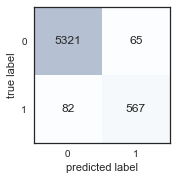

In [124]:
evaluatemodel(ExtraTreesClassifier(random_state=2, n_estimators=500, max_features=0.2), "ExtraTrees")

normal data distribution: Counter({0: 26796, 1: 3375})
SMOTE data distribution: Counter({0: 26796, 1: 26796})
Confusion Matrix: 

SMOTE Pipeline Score 0.7265948632974316

SMOTE + GradientBoost classification
accuracy: 0.7265948632974316
precision: 0.2295973884657236
recall: 0.6432926829268293
f2: 0.47288211564320937


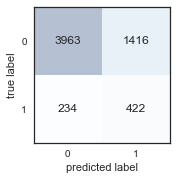

In [359]:
evaluatemodel(GradientBoostingClassifier(random_state=2), "GradientBoost")

normal data distribution: Counter({0: 26796, 1: 3375})
SMOTE data distribution: Counter({0: 26796, 1: 26796})
Confusion Matrix: 

SMOTE Pipeline Score 0.628003314001657

SMOTE + LogisticRegression classification
accuracy: 0.628003314001657
precision: 0.16826722338204592
recall: 0.614329268292683
f2: 0.4014743972902969


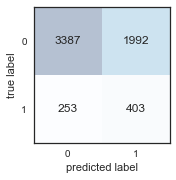

In [360]:
evaluatemodel(LogisticRegression(random_state = 2), "LogisticRegression")

In [361]:
evaluatemodel(SVC(random_state=2), "SVM")

KeyboardInterrupt: 

normal data distribution: Counter({0: 26796, 1: 3375})
SMOTE data distribution: Counter({0: 26796, 1: 26796})
Confusion Matrix: 

SMOTE Pipeline Score 0.9216238608119304

SMOTE + DecisionTree classification
accuracy: 0.9216238608119304
precision: 0.5968253968253968
recall: 0.8597560975609756
f2: 0.7901372933594845


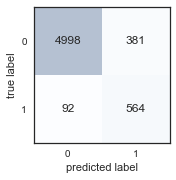

In [362]:
evaluatemodel(DecisionTreeClassifier(random_state=2), "DecisionTree")

normal data distribution: Counter({0: 26796, 1: 3375})
SMOTE data distribution: Counter({0: 26796, 1: 26796})
Confusion Matrix: 

SMOTE Pipeline Score 0.5060480530240266

SMOTE + MLP classification
accuracy: 0.5060480530240266
precision: 0.15798764342453664
recall: 0.8185975609756098
f2: 0.44579113398638553


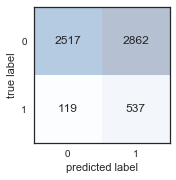

In [363]:
evaluatemodel(MLPClassifier(random_state=2), "MLP")

normal data distribution: Counter({0: 26796, 1: 3375})
SMOTE data distribution: Counter({0: 26796, 1: 26796})
Confusion Matrix: 
[[5290   80]
 [  91  574]]

SMOTE Pipeline Score 0.9716652858326429

SMOTE + RandomForest classification
accuracy: 0.9716652858326429
precision: 0.8776758409785933
recall: 0.8631578947368421
f2: 0.8660229330114664
AUC: 0.9476516710771341


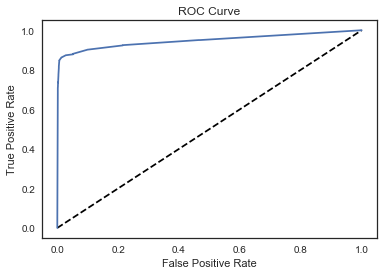

In [108]:
def print_results(headline, true_value, pred):
    print(headline)
    print("accuracy: {}".format(accuracy_score(true_value, pred)))
    print("precision: {}".format(precision_score(true_value, pred)))
    print("recall: {}".format(recall_score(true_value, pred)))
    print("f2: {}".format(fbeta_score(true_value, pred, beta=2)))

# splitting data into training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=4, test_size=0.20)

# build model with SMOTE imblearn
smote_pipeline = make_pipeline_imb(SMOTE(random_state=6), RandomForestClassifier(random_state=2))

smote_model = smote_pipeline.fit(X_train, y_train)
smote_prediction = smote_model.predict(X_test)

print("normal data distribution: {}".format(Counter(y)))
X_smote, y_smote = SMOTE().fit_sample(X, y)
print("SMOTE data distribution: {}".format(Counter(y_smote)))
    
print("Confusion Matrix: ")
print(confusion_matrix(y_test, smote_prediction))
#plot_confusion_matrix(confusion_matrix(y_test, smote_prediction))

print('\nSMOTE Pipeline Score {}'.format(smote_pipeline.score(X_test, y_test)))

print_results("\nSMOTE + RandomForest classification", y_test, smote_prediction)
    
# Compute predicted probabilities: y_pred_prob
y_pred_prob = smote_pipeline.predict_proba(X_test)[:,1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
print('AUC:', auc(fpr, tpr))
# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

## Cross Validation

In [177]:
# Cross validate model with Kfold stratified cross val
kfold = StratifiedKFold(n_splits=10)

In [206]:
# Modeling step Test differents algorithms 
random_state = 2
classifiers = []
classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state),random_state=random_state,learning_rate=0.1))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(LogisticRegression(random_state = random_state))
classifiers.append(SVC(random_state=random_state))
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(MLPClassifier(random_state=random_state))

cv_results = []
for classifier in classifiers :
    cv_results.append(cross_val_score(classifier, X_train, y = y_train, scoring = "f1", cv = kfold, n_jobs=4))

cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

cv_res = pd.DataFrame({"CrossValMeans":cv_means,"CrossValerrors": cv_std,"Algorithm":["AdaBoost",
"RandomForest","ExtraTrees","GradientBoosting", "LogisticRegression", "SVC", "DescisionTree", "MLP"]})

g = sns.barplot("CrossValMeans","Algorithm",data = cv_res, palette="Set3",orient = "h",**{'xerr':cv_std})
g.set_xlabel("Mean Recall")
g = g.set_title("Cross validation scores")

Process ForkPoolWorker-266:
Process ForkPoolWorker-265:
Process ForkPoolWorker-268:
Process ForkPoolWorker-267:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/yingxinkang/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Users/yingxinkang/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Users/yingxinkang/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Users/yingxinkang/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Users/yingxinkang/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/yingxinkang/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **se

KeyboardInterrupt: 

## Paramter Tuning

In [126]:
# Adaboost
DTC = DecisionTreeClassifier()

adaDTC = AdaBoostClassifier(DTC, random_state=7)

ada_param_grid = {"base_estimator__criterion" : ["gini", "entropy"],
              "base_estimator__splitter" :   ["best", "random"],
              "algorithm" : ["SAMME","SAMME.R"],
              "n_estimators" :[100,200],
              "learning_rate":  [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3,1.5]}

gsadaDTC = GridSearchCV(adaDTC,param_grid = ada_param_grid, cv=kfold, scoring="f1", n_jobs= 4, verbose = 1)

gsadaDTC.fit(X_train,y_train)

print(gsadaDTC.best_params_)

ada_best = gsadaDTC.best_estimator_

Fitting 10 folds for each of 112 candidates, totalling 1120 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    8.8s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   19.9s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:   35.1s
[Parallel(n_jobs=4)]: Done 1120 out of 1120 | elapsed:   49.0s finished


{'algorithm': 'SAMME.R', 'base_estimator__criterion': 'entropy', 'base_estimator__splitter': 'best', 'learning_rate': 0.3, 'n_estimators': 2}


In [127]:
gsadaDTC.best_score_

0.8899375508248757

In [128]:
#ExtraTrees 
ExtC = ExtraTreesClassifier()


## Search grid for optimal parameters
ex_param_grid = {"max_depth": [None],
              "max_features": [0.2, 0.5],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[100,300],
              "criterion": ['gini', 'entropy']}


gsExtC = GridSearchCV(ExtC,param_grid = ex_param_grid, cv=kfold, scoring="f1", n_jobs= 4, verbose = 1)

gsExtC.fit(X_train,y_train)

ExtC_best = gsExtC.best_estimator_

Fitting 10 folds for each of 54 candidates, totalling 540 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   41.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  1.7min
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  5.4min
[Parallel(n_jobs=4)]: Done 540 out of 540 | elapsed:  7.3min finished


AttributeError: 'ExtraTreesClassifier' object has no attribute 'best_params_'

In [129]:
print(gsExtC.best_params_)

# Best score
gsExtC.best_score_

{'bootstrap': False, 'criterion': 'gini', 'max_depth': None, 'max_features': 1, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 300}


0.9092800386025509

In [130]:
# RFC Parameters tunning 
RFC = RandomForestClassifier()


## Search grid for optimal parameters
rf_param_grid = {"max_depth": [None],
              "max_features": [0.2, 0.5],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[100,300],
              "criterion": ['gini', 'entropy']}


gsRFC = GridSearchCV(RFC,param_grid = rf_param_grid, cv=kfold, scoring="f1", n_jobs= 4, verbose = 1)

gsRFC.fit(X_train,y_train)

RFC_best = gsRFC.best_estimator_

print(gsRFC.best_params_)

# Best score
gsRFC.best_score_

Fitting 10 folds for each of 54 candidates, totalling 540 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   52.7s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  2.6min
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  9.2min
[Parallel(n_jobs=4)]: Done 540 out of 540 | elapsed: 13.3min finished


{'bootstrap': False, 'criterion': 'gini', 'max_depth': None, 'max_features': 3, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 100}


0.9084727611383275

## Learning Curve

In [145]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    """Generate a simple plot of the test and training learning curve"""
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

In [ ]:
g = plot_learning_curve(gsRFC.best_estimator_,"RF learning curves", X_train,y_train,(0.7, 1.01),cv=kfold)
g = plot_learning_curve(gsExtC.best_estimator_,"ExtraTrees learning curves",X_train,y_train,(0.7, 1.01),cv=kfold)
g = plot_learning_curve(gsadaDTC.best_estimator_,"AdaBoost learning curves",X_train,y_train,(0.7, 1.01),cv=kfold)

## ensemble modeling

In [153]:
random_state = 2
classifiers = []
gbc = GradientBoostingClassifier(random_state=random_state)
classifiers.append(gbc)
lr = LogisticRegression(random_state = random_state)
classifiers.append(lr)
svc = SVC(random_state=random_state)
classifiers.append(svc)
dt = DecisionTreeClassifier(random_state=random_state)
classifiers.append(dt)
mlp = MLPClassifier(random_state=random_state)
classifiers.append(mlp)
for classifier in classifiers:
    classifier.fit(X_train, y_train)

In [154]:
test_purchased_GBV = pd.Series(gbc.predict(X_test), name="GBC")
test_purchased_LR = pd.Series(lr.predict(X_test), name="LR")
test_purchased_SVC = pd.Series(svc.predict(X_test), name="SVC")
test_purchased_DT = pd.Series(dt.predict(X_test), name="DT")
test_purchased_MLP = pd.Series(mlp.predict(X_test), name="MLP")

In [155]:
test_purchased_RFC = pd.Series(RFC_best.predict(X_test), name="RFC")
test_purchased_ExtC = pd.Series(ExtC_best.predict(X_test), name="ExtC")
test_purchased_AdaC = pd.Series(ada_best.predict(X_test), name="Ada")

# Concatenate all classifier results
ensemble_results = pd.concat([test_purchased_RFC,test_purchased_ExtC,test_purchased_AdaC, test_purchased_GBV, test_purchased_LR, test_purchased_SVC, test_purchased_DT, test_purchased_MLP],axis=1)

g= sns.heatmap(ensemble_results.corr(),annot=True)

NameError: name 'RFC_best' is not defined

In [156]:
train = pd.concat([X_train, y_train], 1)
test = pd.concat([X_test, y_test], 1)

In [157]:
from sklearn.cross_validation import KFold

In [158]:
ntrain = train.shape[0]
ntest = test.shape[0]
SEED = 0 # for reproducibility
NFOLDS = 5 # set folds for out-of-fold prediction
kf = KFold(ntrain, n_folds= NFOLDS, random_state=SEED)

In [159]:
# Class to extend the Sklearn classifier
class SklearnHelper(object):
    def __init__(self, clf, model_name, seed=0, params=None):
        if seed != None:
            params['random_state'] = seed
        self.clf = clf(**params)
        self.name = model_name

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict(x)
    
    def predict_proba(self, x):
        return self.clf.predict_proba(x)
    
    def score(self, x, y):
        return self.clf.score(x, y)
    
    def fit(self,x,y):
        try:
            return self.clf.fit(x,y)
        except AttributeError:
            return self.clf.train(x,y)
    
    def feature_importances(self,x,y):
        print(self.clf.fit(x,y).feature_importances_)
        
    def model_name(self):
        return self.name

In [160]:
def get_oof(clf, x_train, y_train, x_test):
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))
    oof_test_skf = np.empty((NFOLDS, ntest))

    for i, (train_index, test_index) in enumerate(kf):
        x_tr = x_train[train_index]
        y_tr = y_train[train_index]
        x_te = x_train[test_index]

        clf.train(x_tr, y_tr)

        oof_train[test_index] = clf.predict(x_te)
        oof_test_skf[i, :] = clf.predict(x_test)

    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)

In [166]:
def get_oof(clf, x_train, y_train, x_test):
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))
    oof_test_skf = np.empty((NFOLDS, ntest))
    train_accuracy = 0
    test_accuracy = 0

    for i, (train_index, test_index) in enumerate(kf):
        x_tr = x_train[train_index]
        y_tr = y_train[train_index]
        x_te = x_train[test_index]
        y_te = y_train[test_index]

        clf.fit(x_tr, y_tr)

        oof_train[test_index] = clf.predict_proba(x_te)[:, 0]
        oof_test_skf[i, :] = clf.predict_proba(x_test)[:, 0]
        train_accuracy += clf.score(x_tr, y_tr)
        test_accuracy += clf.score(x_te, y_te)
    
    train_accuracy = train_accuracy/len(kf)
    test_accuracy = test_accuracy/len(kf)
#    print('train accuracy: '%(clf.model_name(), train_accuracy))
#    print('test accuracy: '%(clf.model_name(), test_accuracy))
    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)

In [162]:
rf_params = {
    'bootstrap': False, 
    'criterion': 'gini',
    'max_depth': None, 
    'max_features': 3, 
    'min_samples_leaf': 1, 
    'min_samples_split': 3, 
    'n_estimators': 100,
    'n_jobs': -1,
    'warm_start': True, 
    'verbose': 0
}

# Extra Trees Parameters
et_params = {
    'bootstrap': False, 
    'criterion': 'gini', 
    'max_depth': None, 
    'max_features': 1, 
    'min_samples_leaf': 1, 
    'min_samples_split': 3,
    'n_estimators': 300,
    'n_jobs': -1,
    'verbose': 0
}

# AdaBoost parameters
ada_params = {
    'algorithm': 'SAMME.R', 
    'learning_rate': 0.3, 
    'n_estimators': 2,
}

# Gradient Boosting parameters
gb_params = {
    'n_estimators': 500,
     #'max_features': 0.2,
    'max_depth': 3,
    'subsample':0.5,
    'min_samples_leaf': 2,
    'verbose': 0
}

# Support Vector Classifier parameters 
svc_params = {
    'kernel' : 'poly',
    'C' : 0.025 ,
    'probability' : True
    }
gbm_params = {
    'learning_rate' : 0.4,
    'n_estimators' : 500,
    'max_depth' : 4,
    'min_child_weight': 2,
    #gamma=1,
    'gamma':0.9,                        
    'subsample':0.5,
    'colsample_bytree':0.8,
    'objective': 'binary:logistic',
    'reg_lambda':5,
    'nthread':-1,
    'scale_pos_weight':1
}

In [163]:
rf = SklearnHelper(RandomForestClassifier, 'RandomForest', seed=SEED, params=rf_params) # 
et = SklearnHelper(ExtraTreesClassifier, 'ExtraTrees',seed=SEED, params=et_params)
ada = SklearnHelper(AdaBoostClassifier, 'adaboost', seed=SEED, params=ada_params)
gb = SklearnHelper(GradientBoostingClassifier, 'GradientBoosting', seed=SEED, params=gb_params)
svc = SklearnHelper(SVC, 'SVM',seed=SEED, params=svc_params)
gbm = SklearnHelper(xgb.XGBClassifier, 'XGB', seed=SEED, params=gbm_params)

In [164]:
try:
    y_train = train['purchase'].ravel()
    train = train.drop(['purchase'], axis=1)
    y_test = test['purchase'].ravel()
    test = test.drop(['purchase'], axis=1)
except KeyError:
    print('no need')
x_train = train.values # Creates an array of the train data
x_test = test.values # Creats an array of the test data

In [167]:
et_oof_train, et_oof_test = get_oof(et, x_train, y_train, x_test) # Extra Trees
print("Training is complete")

Training is complete


In [168]:
rf_oof_train, rf_oof_test = get_oof(rf,x_train, y_train, x_test) # Random Forest
print("Training is complete")

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:305: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  warn("Warm-start fitting without increasing n_estimators does not "


Training is complete


In [169]:
ada_oof_train, ada_oof_test = get_oof(ada, x_train, y_train, x_test) # AdaBoost
print("Training is complete")

Training is complete


In [170]:
gb_oof_train, gb_oof_test = get_oof(gb,x_train, y_train, x_test) # Gradient Boost
print("Training is complete")

Training is complete


In [171]:
svc_oof_train, svc_oof_test = get_oof(svc,x_train, y_train, x_test) # Support Vector Classifier
print("Training is complete")

Training is complete


In [172]:
gbm_oof_train, gbm_oof_test = get_oof(gbm, x_train, y_train, x_test) #XGBoost
print("Training is complete")

Training is complete


In [173]:
base_predictions_train = pd.DataFrame( {'RandomForest': rf_oof_train.ravel(),
     'ExtraTrees': et_oof_train.ravel(),
     'AdaBoost': ada_oof_train.ravel(),
      'GradientBoost': gb_oof_train.ravel(),
     'XGBoost': gbm_oof_train.ravel()
    })
base_predictions_train.head()

,RandomForest,ExtraTrees,AdaBoost,GradientBoost,XGBoost
0,1.000,0.998333,0.888017,0.976503,0.995597
1,0.955,0.891667,0.888017,0.932496,0.981201
2,0.980,0.985000,0.835472,0.901109,0.994407
3,0.985,0.966667,0.888017,0.942108,0.922541
4,1.000,1.000000,0.888017,0.870603,0.904419


In [174]:
x_train = np.concatenate(( et_oof_train, rf_oof_train, ada_oof_train, gb_oof_train, gbm_oof_train), axis=1)
x_test = np.concatenate(( et_oof_test, rf_oof_test, ada_oof_test, gb_oof_test, gbm_oof_test), axis=1)

In [175]:
gbm = xgb.XGBClassifier(
    #learning_rate = 0.02,
 n_estimators= 2000,
 max_depth= 4,
 min_child_weight= 2,
 #gamma=1,
 gamma=0.9,                        
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread= -1,
 scale_pos_weight=1).fit(x_train, y_train)
#predictions = gbm.predict(x_test)

In [183]:
def print_results():
    print("SMOTE + Second Level XGBoost classification")
    print('accuracy:',cross_val_score(gbm, x_train, y = y_train, scoring = "accuracy", cv = kfold, n_jobs=4).mean())
    print('precision:',cross_val_score(gbm, x_train, y = y_train, scoring = "precision", cv = kfold, n_jobs=4).mean())
    print('recall:',cross_val_score(gbm, x_train, y = y_train, scoring = "recall", cv = kfold, n_jobs=4).mean())
    print('f1:',cross_val_score(gbm, x_train, y = y_train, scoring = "f1", cv = kfold, n_jobs=4).mean())

In [178]:
cross_val_score(gbm, x_train, y = y_train, scoring = "f1", cv = kfold, n_jobs=4).mean()

0.9691182211023621


SMOTE + Second Level XGBoost classification
accuracy: 0.9777961888980945
precision: 0.9633507853403142
recall: 0.8300751879699249
f2: 0.8536962573461181


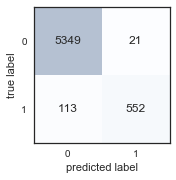

In [142]:
predictions = gbm.predict(x_test)
plot_confusion_matrix(confusion_matrix(y_test, predictions))
print_results("\nSMOTE + Second Level XGBoost classification", y_test, predictions)

Confusion Matrix: 
[[5223  252]
 [  96  572]]
SMOTE + Second Level XGBoost classification
accuracy: 0.9934483034971235
precision: 0.9830657613194089
recall: 0.957090909090909
f1: 0.9691182211023621
AUC: 0.9051300139447134


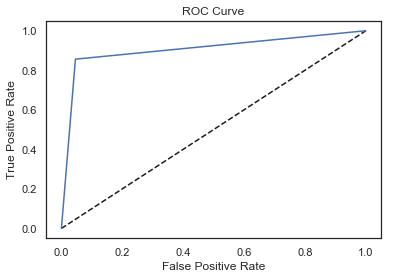

In [185]:
smote_prediction = gbm.predict(x_test)
print("Confusion Matrix: ")
print(confusion_matrix(y_test, smote_prediction))
#plot_confusion_matrix(confusion_matrix(y_test, smote_prediction))

#print_results("\nSMOTE + Second Level XGBoost classification", y_test, smote_prediction)
print_results()

# Compute predicted probabilities: y_pred_prob
#y_pred_prob = smote_pipeline.predict_proba(x_test)[:,1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, smote_prediction)
print('AUC:', auc(fpr, tpr))
# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

In [186]:
(5328+569) /(5328+569+29+109)

0.9771333885666943

In [189]:
print('SMOTE + Second Level XGBoost classification')
print('accuracy:',(5328+569) /(5328+569+29+109))
precision = (569) /(569+29)
recall = (569) /(569+109)
print('precision:',precision)
print('recall:',recall)
print('f1:',cross_val_score(gbm, x_train, y = y_train, scoring = "f1", cv = kfold, n_jobs=4).mean())

SMOTE + Second Level XGBoost classification
accuracy: 0.9771333885666943
precision: 0.9515050167224081
recall: 0.8392330383480826
f1: 0.9691182211023621


normal data distribution: Counter({0: 27296, 1: 3418})
SMOTE data distribution: Counter({0: 27296, 1: 27296})
Confusion Matrix: 
[[5223  252]
 [  96  572]]

SMOTE Pipeline Score 0.9433501546475663

SMOTE + Second Level XGBoost classification
accuracy: 0.9433501546475663
precision: 0.6941747572815534
recall: 0.8562874251497006
f2: 0.8180778032036613
AUC: 0.9263198261012221


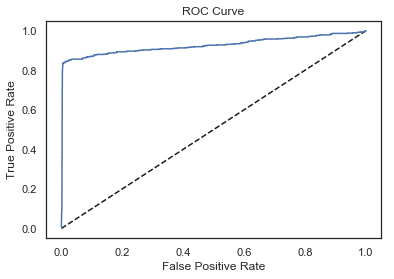

In [179]:
# build model with SMOTE imblearn
smote_pipeline = make_pipeline_imb(SMOTE(random_state=5), gbm)

smote_model = smote_pipeline.fit(x_train, y_train)
smote_prediction = smote_model.predict(x_test)

print("normal data distribution: {}".format(Counter(y)))
X_smote, y_smote = SMOTE().fit_sample(X, y)
print("SMOTE data distribution: {}".format(Counter(y_smote)))
    
print("Confusion Matrix: ")
print(confusion_matrix(y_test, smote_prediction))
#plot_confusion_matrix(confusion_matrix(y_test, smote_prediction))

print('\nSMOTE Pipeline Score {}'.format(smote_pipeline.score(x_test, y_test)))

print_results("\nSMOTE + Second Level XGBoost classification", y_test, smote_prediction)
    
# Compute predicted probabilities: y_pred_prob
y_pred_prob = smote_pipeline.predict_proba(x_test)[:,1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
print('AUC:', auc(fpr, tpr))
# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

In [209]:
votingC = VotingClassifier(estimators=[('rfc', RFC_best), ('extc', ExtC_best), ('ada', ada_best)], voting='soft', n_jobs=4)

votingC = votingC.fit(X_train, y_train)

In [210]:
cvs = cross_val_score(votingC, X_train, y = y_train, scoring = "f1", cv = kfold, n_jobs=4)
cvs.mean()

0.9048321357990454

normal data distribution: Counter({0: 26796, 1: 3375})
SMOTE data distribution: Counter({0: 26796, 1: 26796})
Confusion Matrix: 

SMOTE Pipeline Score 0.9743164871582436

SMOTE + ExtraTrees Best classification
accuracy: 0.9743164871582436
precision: 0.9181969949916527
recall: 0.8384146341463414
f2: 0.8532423208191127


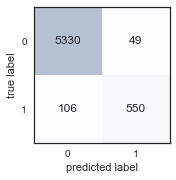

In [151]:
evaluatemodel(ExtC_best, "ExtraTrees Best")

## Feature Importance

In [263]:
rfc = RandomForestClassifier(random_state=2, bootstrap=False, criterion='gini', max_depth=None, max_features=0.2, 
                             min_samples_leaf=1, min_samples_split=3, n_estimators=300).fit(X_train, y_train)

In [264]:
cols = ent_summary.drop(['purchase'], 1).columns.values
# Create a dataframe with features
feature_dataframe = pd.DataFrame( {'features': cols,
     'feature importances': rfc.feature_importances_
    })

In [265]:
feature_dataframe = feature_dataframe.sort_values(by=['feature importances'], ascending=False)

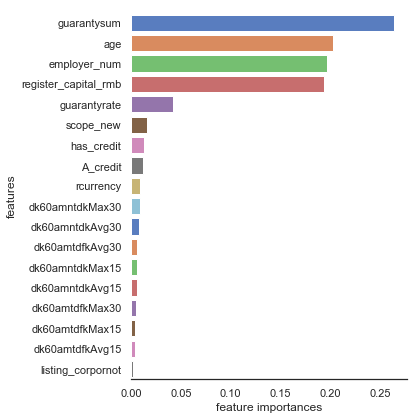

In [266]:
g = sns.factorplot(x="feature importances",y="features",data=feature_dataframe,kind="bar", size = 6 , 
palette = "muted")
g.despine(left=True)

In [252]:
feature_dataframe

,features,feature importances
6,guarantysum,0.258311
2,employer_num,0.202750
21,age,0.201005
4,register_capital_rmb,0.184304
5,guarantyrate,0.044074
19,has_credit,0.017255
1,scope_new,0.016653
0,rcurrency,0.010385
9,dk60amntdkAvg30,0.010106
20,A_credit,0.009214
